## Problem statement

Refer readme section for more information.

In [10]:
#Package Installations
!pip install -r requirements.txt

In [23]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.0 MB/s eta 0:00:00


In [11]:
!pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

  Using cached https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz (2.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached mutagen-1.47.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached pycryptodomex-3.19.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached websockets-12.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl.metadata (2.2 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached Brotli-1.1.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.5 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-manylinux_2_17_x86_64.man

## Data


In [12]:
# this time we are downloading the video from youtube via youtube_dl library for keyframe extraction/scene extraction.

import os
import cv2
import shutil
import yt_dlp as youtube_dl
    
video_url = "https://www.youtube.com/watch?v=ulxDhZIaSCU"  # The Youtube URL
path = "/home/jupyter/object_detection/apporach2/frames_key"

if os.path.exists(path):
    shutil.rmtree(path)
    os.makedirs(path)
else:
    os.makedirs(path)

vd_file_name = os.getcwd() + '/' + 'vd_down'
ydl_opts = {'outtmpl': f'{str(vd_file_name)}'}
ydl = youtube_dl.YoutubeDL(ydl_opts)
info_dict = ydl.extract_info(video_url, download=True)

[youtube] Extracting URL: https://www.youtube.com/watch?v=ulxDhZIaSCU
[youtube] ulxDhZIaSCU: Downloading webpage
[youtube] ulxDhZIaSCU: Downloading ios player API JSON
[youtube] ulxDhZIaSCU: Downloading android player API JSON
[youtube] ulxDhZIaSCU: Downloading m3u8 information
[info] ulxDhZIaSCU: Downloading 1 format(s): 616+251
[download] /home/jupyter/object_detection/apporach2/vd_down.webm has already been downloaded


In [13]:
#path = "/home/jupyter/object_det/object_detection/apporach2/frames_key"

if os.path.exists(path):
    shutil.rmtree(path)
    os.makedirs(path)
else:
    os.makedirs(path)

In [14]:
# We are using ffmpeg library for Key Frame Extraction from the video.
# This code helps us in running the command line code from the script.

import shlex
from subprocess import Popen, PIPE

def get_exitcode_stdout_stderr(cmd):
    """
        Execute the external command and get its exitcode, stdout and stderr.
    """
    args = shlex.split(cmd)
    proc = Popen(args, shell=False, stdout=PIPE, stderr=PIPE)
    proc.communicate()

In [15]:
video_path = os.getcwd() + '/' + 'vd_down.' + info_dict['ext']

cmd = f"""sudo -S ffmpeg -i {video_path} -vf "select='gt(scene,0.4)'" -vsync vfr {path}/frame-%d.jpg"""
get_exitcode_stdout_stderr(cmd)

## Approach

Feel free to choose any algorithm for the task.

In [16]:
import os

def get_frames(path):
    """

    :param path:
    :return:
    """
    frame_path = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith('.jpg'.lower()):
                frame_path.append(os.path.join(root, file))

    return frame_path

frame_path = get_frames(path)

In [17]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('yolov8m.pt')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

In [18]:
from sentence_transformers import SentenceTransformer

clip_model = SentenceTransformer("sentence-transformers/clip-ViT-B-32")

11/20/2023 17:16:03 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: sentence-transformers/clip-ViT-B-32
11/20/2023 17:16:04 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda


In [19]:
import cv2
import imagehash
from PIL import Image

video_info = dict()
frame_info = dict()

for frame in frame_path:
    frame_no = frame.split('/')[-1]
    results = model.predict(frame)
    
    res_dict = dict()
    i2 = cv2.imread(frame)
    
    for result in results:                                          # iterate results
        boxes = result.boxes.cpu().numpy()                          # get boxes on cpu in numpy
        
        for box in boxes:                                           # iterate boxes
            r = box.xyxy[0].astype(int)                             # get corner points as int

            if model.model.names[int(box.cls.item())] == 'person':
                bb_img = i2[r[1]:r[1]+r[3],r[0]:r[0]+r[2]]

                phash = str(imagehash.phash(Image.fromarray(bb_img)))

                if frame_no not in video_info.keys():
                    video_info[frame_no] = {'count': 1, 'co_ord': [r]}
                else:
                    video_info[frame_no]['count'] += 1
                    video_info[frame_no]['co_ord'].append(r)

                if phash not in frame_info.keys():
                    frame_info[phash] = {'count': 1, 'co_ord': [r], 'frame_no': [frame_no]}#, 'bb_embed': [bb_embed]}
                else:
                    frame_info[phash]['count'] += 1
                    frame_info[phash]['co_ord'].append(r)
                    frame_info[phash]['frame_no'].append(frame_no)

Ultralytics YOLOv8.0.8 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14928MiB)
Fusing layers... 
YOLOv8m summary: 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs
Ultralytics YOLOv8.0.8 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14928MiB)
Fusing layers... 
YOLOv8m summary: 218 layers, 25886080 parameters, 0 gradients
Ultralytics YOLOv8.0.8 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14928MiB)
Fusing layers... 
YOLOv8m summary: 218 layers, 25886080 parameters, 0 gradients
Ultralytics YOLOv8.0.8 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14928MiB)
Fusing layers... 
YOLOv8m summary: 218 layers, 25886080 parameters, 0 gradients
Ultralytics YOLOv8.0.8 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14928MiB)
Fusing layers... 
YOLOv8m summary: 218 layers, 25886080 parameters, 0 gradients
Ultralytics YOLOv8.0.8 🚀 Python-3.10.13 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14928MiB)
Fusing layers... 
YOLOv8m summary: 218 layers, 25886080 parameter

In [20]:
import pandas as pd

ft_df = pd.DataFrame(frame_info)
ft_df.transpose().reset_index().to_csv('key_frame_info2.csv')

In [21]:
vd_df = pd.DataFrame(video_info)
vd_df.transpose().reset_index().to_csv('video_info_keyframe.csv')

In [24]:
from datasets import Dataset

frame_dt = Dataset.from_pandas(ft_df.transpose().reset_index())

In [ ]:
import cv2
from PIL import Image

def clip_embed(example):
    i2 = cv2.imread(f'{path}/'+example['frame_no'][0])
    r = example['co_ord'][0]
    
    bb_img = i2[r[1]:r[1]+r[3],r[0]:r[0]+r[2]]
    
    example['embed'] = clip_model.encode(Image.fromarray(bb_img))
    return example
    
frame_dt = frame_dt.map(clip_embed)

Map:   0%|          | 0/407 [00:00<?, ? examples/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
from umap import UMAP

umap_model = UMAP(n_neighbors=28, n_components=128, min_dist=0.28, metric='cosine')
umap_model.fit(frame_dt['embed'])

umap_embeddings = umap_model.transform(frame_dt['embed'])

In [43]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size = 30, metric='euclidean',
                            cluster_selection_method='eom', prediction_data=True)

In [44]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, metric='euclidean', prediction_data=True)
clusterer.fit(umap_embeddings)

HDBSCAN(min_cluster_size=10, prediction_data=True)

In [45]:
cluster_labels = sorted(list(set(clusterer.labels_)))
predicted_clusters = list(clusterer.labels_)
len(predicted_clusters)

407

In [46]:
import joblib

with open('/home/jupyter/object_detection/apporach2/key_frame_bbox_cluster_100.pkl', 'wb') as file:
    joblib.dump(clusterer, file)

In [47]:
frame_dt2 = frame_dt.remove_columns(['embed'])
frame_df = frame_dt2.to_pandas()

In [48]:
frame_df['pred_clusters'] = predicted_clusters

In [49]:
frame_df.pred_clusters.value_counts()

pred_clusters
 0    224
 1    128
-1     55
Name: count, dtype: int64

In [50]:
import pandas as pd

frequency = (
            pd.DataFrame({"Cluster": predicted_clusters, "Count": predicted_clusters})
              .groupby("Cluster")
              .count()
              .drop(-1, errors="ignore")
              .sort_values("Count", ascending=False)
        )

In [51]:
frequency

,Count
Cluster,
0,224
1,128


## Visualization

From the above pipeline, above we want to learn more about the video and people included in them, like, how many frames have multiple people, in how many frames does person X appear, who has the most screen time, the least screen time.

Use above pipeline results to create visualizations that explore the contents of the video.

<Axes: ylabel='$\\lambda$ value'>

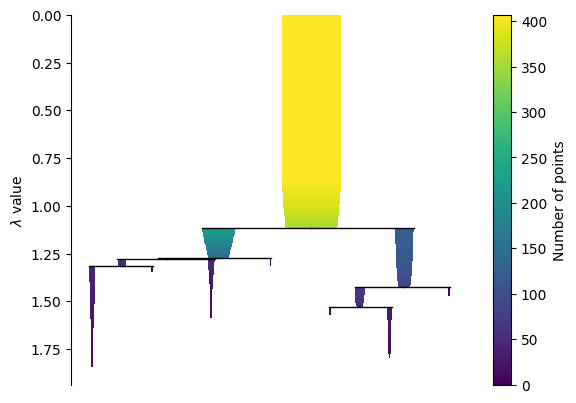

In [149]:
clusterer.condensed_tree_.plot()

### Frames with maximum count

In [156]:
vd_df2 = vd_df.transpose().reset_index()
vd_df2 = vd_df2.sort_values(by=['count'], ascending=False)

In [174]:
vd_df2.head()

,index,count,co_ord
38,frame-51.jpg,12,"[[1469, 290, 1794, 1072], [2, 4, 568, 1062], [..."
25,frame-83.jpg,10,"[[891, 105, 1509, 1072], [399, 202, 988, 1074]..."
15,frame-50.jpg,9,"[[182, 94, 934, 1065], [864, 289, 1086, 894], ..."
14,frame-136.jpg,8,"[[1310, 134, 1917, 1064], [659, 128, 1006, 477..."
106,frame-97.jpg,8,"[[2, 64, 942, 1072], [730, 128, 1398, 1062], [..."


In [171]:
import cv2
import matplotlib.pyplot as plt

def display_picture(co_ord, frame_no):

    image = cv2.imread(f'{path}/' + frame_no)
    r = co_ord[0].tolist()
    
    bb_img = image[r[1]:r[1]+r[3],r[0]:r[0]+r[2]]
    plt.imshow(bb_img)

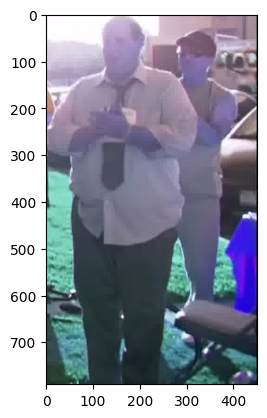

In [173]:
## Printing Frames with Highest Count
display_picture(vd_df2['co_ord'].iloc[0], vd_df2['index'].iloc[0])

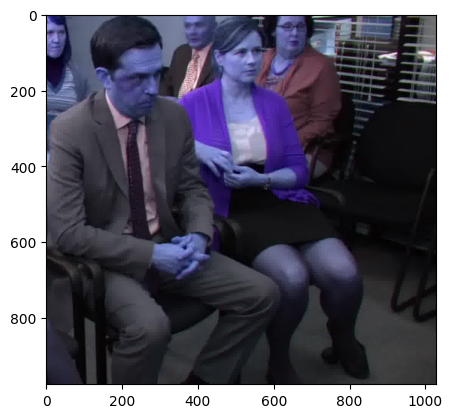

In [175]:
## Printing Frames with Highest Count
display_picture(vd_df2['co_ord'].iloc[1], vd_df2['index'].iloc[1])

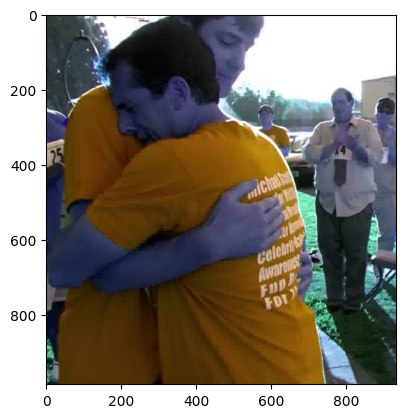

In [176]:
## Printing Frames with Highest Count
display_picture(vd_df2['co_ord'].iloc[2], vd_df2['index'].iloc[2])

In [145]:
# Top 10 Images from Clusters.
import PIL
import numpy as np
from PIL import Image

path2 = f"/home/jupyter/object_detection/apporach2/top_10_per_cluster/"
    
cluster_labels2, strengths = hdbscan.approximate_predict(clusterer, umap_embeddings)

def storing_10_image(df, cluster_num):
    
    path_clus = f"{path2}/cluster_no_{cluster_num}"

    if os.path.exists(path_clus):
        shutil.rmtree(path_clus)
        os.makedirs(path_clus)
    else:
        os.makedirs(path_clus)
    
    img_path = list()
    for i in range(df.shape[0]):
        frame = df['frame_no'].iloc[i]
        image = cv2.imread(f'{path}/' + frame[0])
        
        r = df['co_ord'].iloc[i][0].tolist()

        bb_img = image[r[1]:r[1]+r[3],r[0]:r[0]+r[2]]
        
        im = Image.fromarray(bb_img)
        im.save(f"{path_clus}/image_{i}.jpg")
        img_path.append(f"{path_clus}/image_{i}.jpg")
        
    return img_path
        

def top_10_element(cluster_num, frame_df):
    
    cluster_indices = np.where(cluster_labels2 == cluster_num)[0]
    sorted_indices = sorted(cluster_indices, key=lambda x: clusterer.probabilities_[x], reverse=True)
    top_10_elements = frame_df.iloc[sorted_indices[:10]]
    
    img_path = storing_10_image(top_10_elements, cluster_num)
    
    imgs = [Image.open(i) for i in img_path]
    min_shape = sorted([(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack([i.resize(min_shape) for i in imgs])

    imgs_comb = Image.fromarray(imgs_comb)
    plt.imshow(imgs_comb)

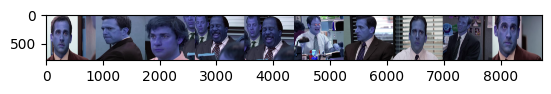

In [146]:
top_10_element(0, frame_df)

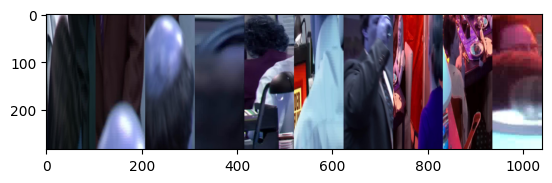

In [147]:
top_10_element(1, frame_df)

## Deployment

In [1]:
# feel free to write code here or create extra .py scripts and Dockerfile for deployment.
# include instructions on how to setup the dockerfile, create a docker image and run it
# include instructions on how to send a Request to this dockerize solution.

## Deliverables

Webserver Code

In [ ]:
## API Request

import requests
import json

BASE_URL = "http://localhost:5000"

def get_people_from_image(image_filepath):
    url = f"{BASE_URL}/get_people_from_image"
    headers = {"Content-Type": "application/json"}
    data = {"image_filepath": image_filepath}

    response = requests.post(url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        result = response.json()
        print("Bounding Boxes:")
        print(result["bounding_boxes"])
        print("Cluster Labels:")
        print(result["cluster_labels"])
    else:
        print(f"Error: {response.status_code}, {response.text}")

# Example usage
image_path = "/path/to/your/image.jpg"
get_people_from_image(image_path)